In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-plate-detection/annotations/Cars339.xml
/kaggle/input/car-plate-detection/annotations/Cars13.xml
/kaggle/input/car-plate-detection/annotations/Cars74.xml
/kaggle/input/car-plate-detection/annotations/Cars16.xml
/kaggle/input/car-plate-detection/annotations/Cars291.xml
/kaggle/input/car-plate-detection/annotations/Cars236.xml
/kaggle/input/car-plate-detection/annotations/Cars429.xml
/kaggle/input/car-plate-detection/annotations/Cars132.xml
/kaggle/input/car-plate-detection/annotations/Cars251.xml
/kaggle/input/car-plate-detection/annotations/Cars51.xml
/kaggle/input/car-plate-detection/annotations/Cars165.xml
/kaggle/input/car-plate-detection/annotations/Cars313.xml
/kaggle/input/car-plate-detection/annotations/Cars240.xml
/kaggle/input/car-plate-detection/annotations/Cars201.xml
/kaggle/input/car-plate-detection/annotations/Cars412.xml
/kaggle/input/car-plate-detection/annotations/Cars227.xml
/kaggle/input/car-plate-detection/annotations/Cars145.xml
/kaggle/input/car-

In [56]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

import torch
print(f"{torch.cuda.is_available() = }")
print(f"{torch.cuda.device_count() = }")

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [57]:
!pip install ultralytics

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [58]:
!pip install -U ipywidgets

In [59]:
dataset_path = '/kaggle/input/car-plate-detection'

In [60]:
import re
def extract_numbers_from_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(0))
    else:
        return 0

In [61]:
print(extract_numbers_from_string("rgb456.txt"))

456


# Extracting parameters from .xml file

In [62]:
# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path = [],
    xmin = [],
    xmax = [],
    ymin = [],
    ymax = [],
    img_width = [],
    img_height = []
)

In [63]:
labels_dict

{'img_path': [],
 'xmin': [],
 'xmax': [],
 'ymin': [],
 'ymax': [],
 'img_width': [],
 'img_height': []}

In [64]:
# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

In [65]:
xml_files

['/kaggle/input/car-plate-detection/annotations/Cars339.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars13.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars74.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars16.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars291.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars236.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars429.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars132.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars251.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars51.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars165.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars313.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars240.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars201.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars412.xml',
 '/kaggle/input/car-plate-detection/annotations/Cars227.xml',
 '/kaggle/in

# Process each XML file, sorted by the numerical value in the filename

In [66]:
for filename in sorted(xml_files, key = extract_numbers_from_string):
        info = xet.parse(filename)
        root = info.getroot()
        #print(info)
        #print(root)
        
        # Find the 'object' element in the XML and extract bounding box information
        member_obj = root.find('object')
        labels_info = member_obj.find('bndbox')
        #print(member_obj, labels_info)
        
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)
        
         # Get the image filename and construct the full path to the image
        img_name = root.find('filename').text
        img_path = os.path.join(dataset_path, 'images', img_name)

        height, width, _ = cv2.imread(img_path).shape # The shape of the image is stored in RGB format i.e., height, width, number of channels
        
        # Append the extracted information to the respective lists in the dictionary
        labels_dict['img_path'].append(img_path)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)
        labels_dict['img_height'].append(height)
        labels_dict['img_width'].append(width)
        #print(labels_dict)

        #break

In [67]:
# Convert the dictionary to a pandas DataFrame
data = pd.DataFrame(labels_dict)

In [68]:
data

,img_path,xmin,xmax,ymin,ymax,img_width,img_height
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


# Splitting the data into 3 sets :
**Train, Validation, Test**

In [69]:
# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(data, test_size = 1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size = 8/9, random_state=42)

In [70]:
# Print the number of samples in each set
print(f'''Length(train) = { len(train) }
Len(validation) = { len(val) }
Len(test) = { len(test) }
''')

Length(train) = 345
Len(validation) = 44
Len(test) = 44



In [71]:
# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

# Splitting the sets into subfolders

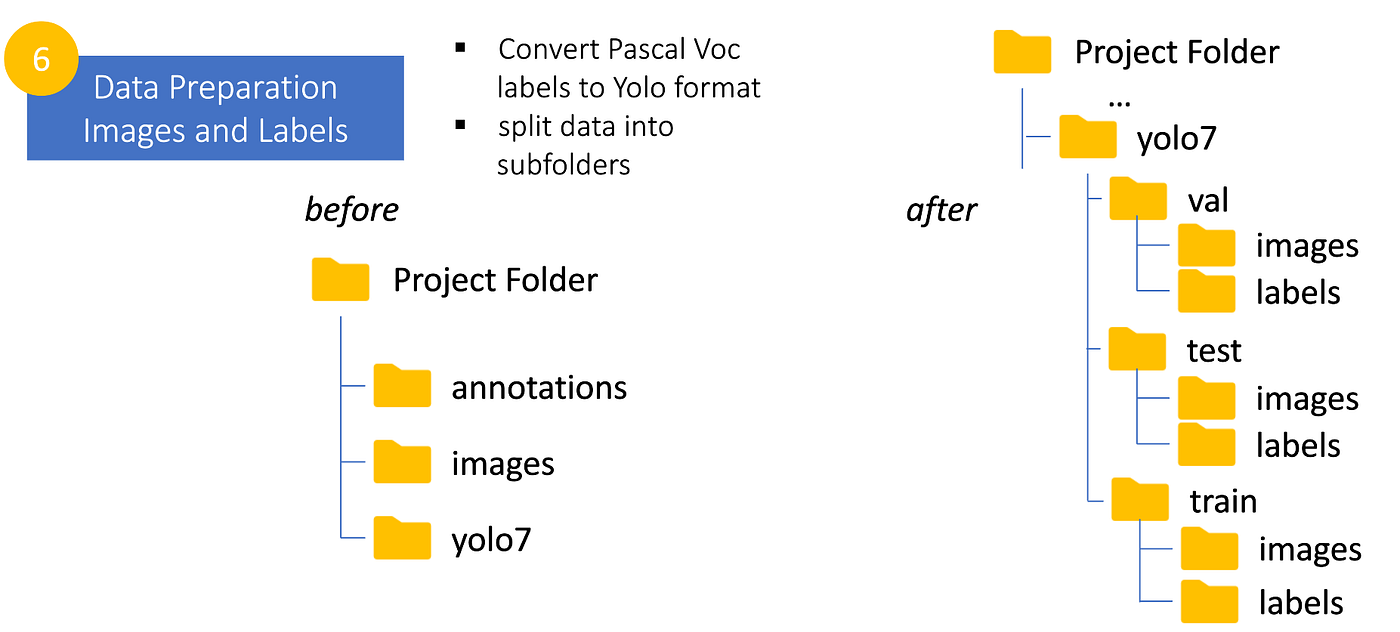

In [72]:
def splitting_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_width']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_height']
        width = (row['xmax'] - row['xmin']) / row['img_width']
        height = (row['ymax'] - row['ymin']) / row['img_height']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [73]:
# Create YOLO format folders for train, validation, and test splits
splitting_folder_in_yolo_format("train", train)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'


In [74]:
# Create YOLO format folders for train, validation, and test splits
splitting_folder_in_yolo_format("val", val)

Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'


In [75]:
splitting_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


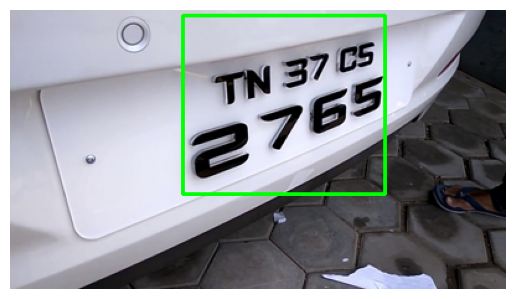

In [76]:
# Directory paths
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[1]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

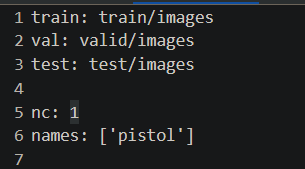

# Replicated the structure indicated above in a .yaml file 

In [77]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [78]:
from ultralytics import YOLO

In [79]:
model = YOLO('yolov9s.pt')

In [80]:
model.train(
    data = 'datasets.yaml',
    epochs = 100,
    batch = 16,
    device = 'cuda',
    imgsz = 320,
    cache = True
)

Ultralytics YOLOv8.2.41 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

wandb: Currently logged in as: khushisharmalive1908 (khushi-sharma). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 469.65it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:02<00:00, 166.31it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 455.60it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 191.81it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.87G      1.767      2.454      1.412         17        320: 100%|██████████| 22/22 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]

                   all         44         44      0.721      0.727      0.717      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.77G      1.507      1.154      1.265         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

                   all         44         44      0.836      0.727      0.741      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.81G      1.498      1.019      1.281         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]

                   all         44         44       0.85      0.386      0.491      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.78G      1.485      1.073       1.27         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

                   all         44         44      0.546      0.574      0.512      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.78G      1.528      1.005       1.32         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.53it/s]

                   all         44         44    0.00605      0.614    0.00493    0.00251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.81G      1.469     0.9136      1.279         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

                   all         44         44      0.668      0.727      0.672      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.78G      1.522     0.9373      1.339         11        320: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.42it/s]

                   all         44         44      0.544      0.159      0.148     0.0703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       1.8G      1.465     0.9005      1.256         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.05it/s]

                   all         44         44      0.544      0.159      0.148     0.0703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.78G      1.397     0.9029      1.268         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.07it/s]

                   all         44         44      0.544      0.159      0.148     0.0703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       1.8G       1.45     0.9206      1.273         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]

                   all         44         44      0.833      0.591      0.615      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.78G      1.441     0.9129      1.296         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

                   all         44         44      0.844      0.727      0.762      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       1.8G      1.462     0.8656       1.26         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.50it/s]

                   all         44         44      0.811      0.591      0.689      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.78G      1.334     0.8276      1.222         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.42it/s]

                   all         44         44     0.0105      0.318    0.00565    0.00296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.81G      1.331     0.8255      1.222         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

                   all         44         44     0.0164      0.159    0.00573    0.00342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.79G      1.379     0.8437      1.213         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         44         44      0.774      0.477      0.515      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       1.8G      1.354     0.8291      1.231         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]

                   all         44         44      0.701      0.659       0.69      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.78G      1.265     0.8121      1.146         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]

                   all         44         44       0.84      0.864      0.866      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       1.8G      1.331     0.7848      1.196         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]

                   all         44         44      0.871      0.818      0.856      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.78G      1.337     0.7682      1.198         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.73it/s]

                   all         44         44      0.818      0.864      0.897        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       1.8G      1.238     0.7695      1.184         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         44         44      0.809      0.886      0.854      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.78G      1.229     0.7135      1.165         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]

                   all         44         44      0.833      0.818       0.88       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.81G      1.218     0.7255      1.147         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

                   all         44         44      0.877      0.795      0.859       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.78G      1.219     0.7493      1.182         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

                   all         44         44      0.863      0.859      0.901      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       1.8G      1.173     0.7085      1.136         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

                   all         44         44      0.877      0.813       0.87      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.78G      1.208     0.7263      1.154         25        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         44         44      0.937      0.818      0.924      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       1.8G      1.186     0.6823      1.126         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]

                   all         44         44      0.885      0.932      0.938      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.78G      1.174     0.6909      1.156         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]

                   all         44         44        0.9      0.818      0.882      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       1.8G      1.145     0.6797      1.123         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

                   all         44         44      0.837      0.864      0.879      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.78G      1.107     0.6367      1.095         21        320: 100%|██████████| 22/22 [00:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.87it/s]

                   all         44         44      0.843      0.864      0.909      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.81G      1.141     0.6691      1.137         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

                   all         44         44      0.878      0.841      0.923      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.78G      1.157     0.6601      1.099         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.50it/s]

                   all         44         44      0.909      0.818      0.869      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       1.8G      1.104     0.6273      1.109         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

                   all         44         44      0.802      0.864      0.867      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.78G      1.105     0.6466      1.101         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.17it/s]

                   all         44         44      0.875      0.841      0.892      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       1.8G      1.103     0.6381       1.11         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.13it/s]

                   all         44         44      0.804      0.795      0.824      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.78G      1.086     0.6239      1.087         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]

                   all         44         44      0.829      0.864      0.895      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       1.8G      1.088     0.6373      1.069         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]

                   all         44         44      0.868      0.864      0.914      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.78G      1.087     0.6574      1.099         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         44         44      0.876      0.864      0.899      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       1.8G      1.039     0.6169      1.065         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

                   all         44         44      0.834      0.932      0.921      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.78G      1.018     0.6006      1.087         10        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

                   all         44         44      0.792      0.951      0.924      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.81G      1.001     0.5798      1.056         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         44         44      0.869      0.795      0.896      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.78G     0.9905     0.5837      1.039         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]

                   all         44         44      0.915      0.734      0.888      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.81G     0.9956     0.5683      1.037         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

                   all         44         44      0.923      0.816      0.925      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.78G      1.012     0.5649      1.061         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]

                   all         44         44      0.831      0.841      0.877      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.81G      1.007      0.569      1.071         12        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]

                   all         44         44      0.816      0.864      0.861      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.78G     0.9955     0.5453      1.044         22        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.60it/s]

                   all         44         44      0.779      0.881      0.848      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       1.8G     0.9768     0.5727      1.046         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.34it/s]

                   all         44         44      0.859      0.864      0.881      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.78G     0.9192     0.5214      1.014         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.70it/s]

                   all         44         44      0.907      0.841      0.883      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       1.8G     0.9705     0.5651      1.054         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.51it/s]

                   all         44         44      0.962      0.795      0.888      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.78G     0.9673     0.5593       1.05         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]

                   all         44         44      0.872      0.776       0.86      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       1.8G     0.9018     0.5332      1.016         23        320: 100%|██████████| 22/22 [00:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

                   all         44         44      0.808      0.864      0.892      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.78G     0.9338     0.5484      1.023         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         44         44      0.847      0.886      0.906       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.81G     0.9248     0.5378      1.035         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

                   all         44         44      0.861      0.864      0.885      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.78G     0.8974     0.5068      1.012         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.60it/s]

                   all         44         44      0.815      0.841      0.879       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       1.8G     0.9555     0.5289      1.023         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.50it/s]

                   all         44         44      0.806      0.818       0.87      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.78G     0.9561     0.5348      1.047         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

                   all         44         44      0.906      0.864      0.938      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.81G     0.9071     0.5099      1.015         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]

                   all         44         44      0.903      0.847      0.939      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.78G     0.9121     0.5089      1.039         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

                   all         44         44      0.907      0.841      0.912      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       1.8G     0.8823     0.5164      1.029         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

                   all         44         44      0.852      0.864       0.88      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.78G     0.8804     0.4932     0.9854         12        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.42it/s]

                   all         44         44       0.84      0.864      0.883      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.81G     0.8316     0.4733      1.009         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]

                   all         44         44       0.82      0.818      0.853      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.78G     0.8294     0.4838     0.9836         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

                   all         44         44      0.778      0.864      0.876      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       1.8G     0.8369      0.489     0.9867         12        320: 100%|██████████| 22/22 [00:04<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         44         44      0.811      0.886      0.869      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.78G     0.8457      0.461     0.9844         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

                   all         44         44      0.815      0.901      0.884      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.81G     0.8749     0.5029      1.015         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

                   all         44         44      0.792      0.864      0.869      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.78G     0.8832     0.4767      1.024         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]

                   all         44         44      0.768      0.905      0.867      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       1.8G     0.8646     0.4673      1.017         12        320: 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.46it/s]

                   all         44         44      0.821      0.832      0.851      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.78G     0.8613     0.4806      1.013         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

                   all         44         44       0.88      0.835      0.908      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       1.8G     0.8399     0.4725      0.991         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

                   all         44         44      0.811      0.886      0.876      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.78G     0.8523     0.4686     0.9899         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]

                   all         44         44      0.811       0.88      0.892       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       1.8G     0.7934     0.4669       0.97         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]

                   all         44         44      0.815      0.886      0.892      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.78G     0.7852     0.4417     0.9539         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         44         44      0.829      0.884      0.871      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.81G      0.791       0.45     0.9679         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

                   all         44         44      0.903      0.851      0.905      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.78G     0.8069     0.4646     0.9941         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]

                   all         44         44      0.904       0.86      0.922      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       1.8G     0.8045     0.4423     0.9745         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]

                   all         44         44       0.82       0.93      0.931      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.78G     0.7644     0.4343     0.9615         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

                   all         44         44      0.811      0.879      0.884      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.81G     0.7397     0.4268     0.9593         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         44         44      0.862      0.841        0.9      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.78G     0.7713     0.4352     0.9563         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

                   all         44         44      0.837      0.932      0.913      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       1.8G       0.75     0.4234     0.9683         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

                   all         44         44      0.815      0.903      0.872      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.78G     0.7571     0.4231     0.9711         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

                   all         44         44      0.797      0.932      0.906       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.81G     0.7392     0.4267     0.9315         21        320: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]

                   all         44         44      0.859      0.864      0.917       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.78G     0.7551     0.4227      0.976         22        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

                   all         44         44      0.863      0.861      0.917      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.81G     0.7556     0.4082     0.9562         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]

                   all         44         44      0.811       0.88      0.895      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.78G      0.753     0.4194     0.9583         22        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.31it/s]

                   all         44         44      0.836      0.928      0.931      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       1.8G     0.7177     0.4005     0.9296         22        320: 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.93it/s]

                   all         44         44      0.808      0.909      0.909      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.78G     0.6939     0.3994     0.9497         22        320: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]

                   all         44         44      0.819      0.932      0.927      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       1.8G     0.7039     0.4003     0.9516         24        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         44         44      0.843      0.864      0.907      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.78G     0.7043     0.3941     0.9589         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]

                   all         44         44      0.874      0.864      0.898       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       1.8G     0.7159     0.4057     0.9647         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

                   all         44         44      0.829      0.883      0.913       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.79G     0.7245     0.4046     0.9508         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.62it/s]

                   all         44         44       0.88      0.841      0.902      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       1.8G     0.6946     0.3824     0.9447         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

                   all         44         44      0.816      0.906      0.899      0.531


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.78G     0.9355     0.4724      1.077          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

                   all         44         44      0.816      0.907      0.888       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       1.8G     0.9741     0.4983      1.058          9        320: 100%|██████████| 22/22 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

                   all         44         44      0.816      0.905      0.894      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.78G     0.9565     0.4628      1.047          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

                   all         44         44       0.81      0.909      0.894      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       1.8G      0.946     0.4375      1.067          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

                   all         44         44      0.816      0.904      0.898      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.78G     0.9326      0.441      1.035          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]

                   all         44         44      0.885      0.818      0.894      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       1.8G     0.8828      0.444      1.041          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]

                   all         44         44      0.816      0.906      0.895      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.78G     0.9121     0.4371       1.03          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         44         44      0.816      0.907      0.897      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       1.8G     0.9075     0.4517      1.005          8        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

                   all         44         44       0.82      0.929       0.93      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.78G     0.8793     0.4233      1.039          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

                   all         44         44      0.808      0.886      0.899      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       1.8G     0.9188     0.4434      1.032          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

                   all         44         44      0.799      0.904      0.894      0.561



100 epochs completed in 0.198 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 15.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.41 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9s summary (fused): 486 layers, 7167475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


                   all         44         44      0.904      0.859      0.922      0.587
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 9.9ms postprocess per image
Results saved to runs/detect/train4


lr/pg0,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▆▅▆▂▇▁▆▇████▇▇███▇█▇█▇███▇██████████████
metrics/mAP50-95(B),▅▄▅▂▆▁▅▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇████
metrics/precision(B),▇▇▆▅▇▁▆█▇██▇█▇█▇█▇██▇▇█▇▇▇█▇█▇▇▇▇▇██▇▇▇█
metrics/recall(B),▆▃▆▁▆▂▅▇▇▇█▇▇▇▇█▆▇▇▆▇▇▇▇▇▇▇▇▇███▇█▇▇███▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▃▃▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6cac52ddb0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [81]:
# Save the trained model
model.save('best_license_plate_model.pt')

# Model Evaluation

In [82]:
# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key = extract_numbers_from_string)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.76650,2.45370,1.4123,0.72120,0.72727,0.71668,0.33270,1.7597,1.62100,1.4417,0.000420,0.000420,0.000420
1,2,1.50750,1.15420,1.2653,0.83604,0.72727,0.74143,0.33172,1.8196,1.26100,1.4734,0.000851,0.000851,0.000851
2,3,1.49770,1.01940,1.2813,0.84971,0.38553,0.49109,0.27633,1.7518,1.71270,1.5141,0.001274,0.001274,0.001274
3,4,1.48470,1.07310,1.2703,0.54591,0.57387,0.51187,0.25672,2.3691,1.60260,1.8248,0.001688,0.001688,0.001688
4,5,1.52780,1.00540,1.3202,0.00605,0.61364,0.00493,0.00251,1.9638,251.09000,1.6400,0.001921,0.001921,0.001921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.88281,0.44399,1.0411,0.81579,0.90591,0.89497,0.55683,1.4861,0.67873,1.3384,0.000119,0.000119,0.000119
96,97,0.91212,0.43713,1.0303,0.81593,0.90675,0.89680,0.56671,1.4813,0.67255,1.3479,0.000099,0.000099,0.000099
97,98,0.90754,0.45168,1.0045,0.81957,0.92915,0.93046,0.56325,1.4288,0.64438,1.3147,0.000079,0.000079,0.000079
98,99,0.87928,0.42334,1.0390,0.80768,0.88636,0.89937,0.55480,1.4371,0.63937,1.3121,0.000060,0.000060,0.000060


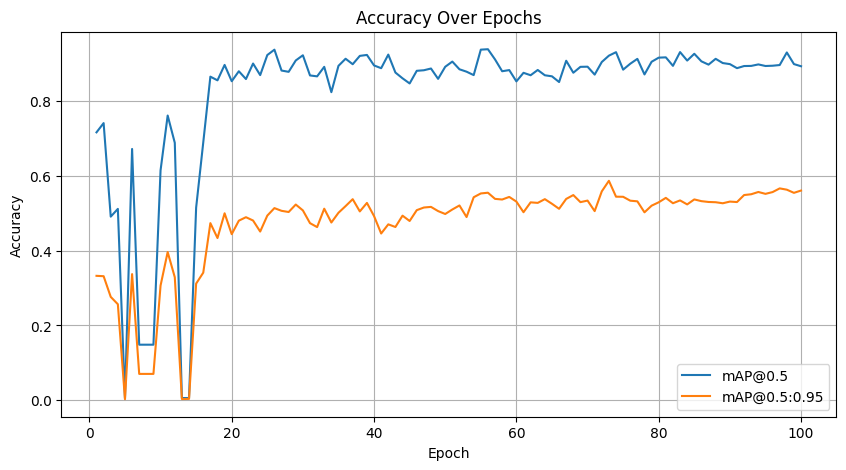

In [83]:
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/working/datasets/cars_license_plate_new/test/images/Cars323.png: 192x320 1 license_plate, 92.4ms
Speed: 0.7ms preprocess, 92.4ms inference, 0.9ms postprocess per image at shape (1, 3, 192, 320)


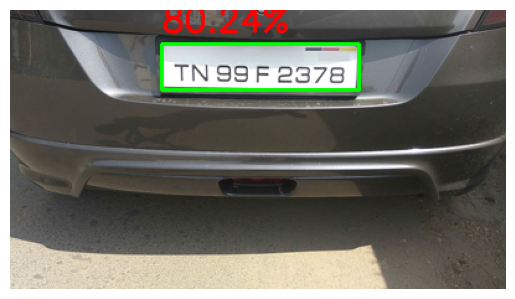

In [85]:
predict_and_plot('/kaggle/working/datasets/cars_license_plate_new/test/images/Cars323.png')

# Reading License Plates (Using OCR)

In [86]:
!pip3 install pytesseract

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [87]:
import pytesseract
from pytesseract import Output

In [88]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.
    
    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = gray_image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi,lang='eng', config = r'--oem 3 --psm 6')
            cv2.putText(image, f'{text}', (x1, y1 + y2), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 123, 0), 2)
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/working/datasets/cars_license_plate_new/test/images/Cars415.png: 256x320 1 license_plate, 112.5ms
Speed: 1.4ms preprocess, 112.5ms inference, 1.0ms postprocess per image at shape (1, 3, 256, 320)
Detected text: MH 14@NE e922



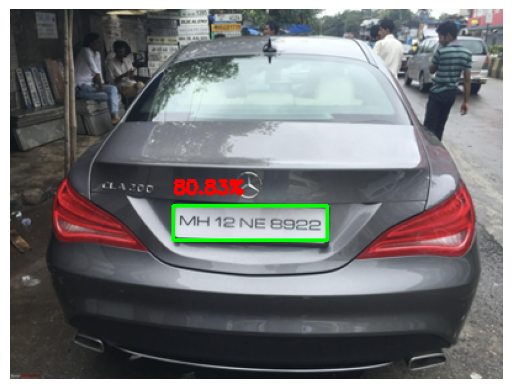

In [89]:
predict_and_plot('/kaggle/working/datasets/cars_license_plate_new/test/images/Cars415.png')

# Using EasyOCR

In [90]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.
    
    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    reader = easyocr.Reader(['en']) 

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = gray_image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = reader.readtext(roi)
            if len(text) > 0:
                text = text[0][1]
            cv2.putText(image, f'{text}', (x1, y1 + 40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 123, 255), 2)
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image

In [91]:
import easyocr


image 1/1 /kaggle/working/datasets/cars_license_plate_new/test/images/Cars415.png: 256x320 1 license_plate, 111.5ms
Speed: 1.0ms preprocess, 111.5ms inference, 0.8ms postprocess per image at shape (1, 3, 256, 320)
Detected text: MH1ZNE B922


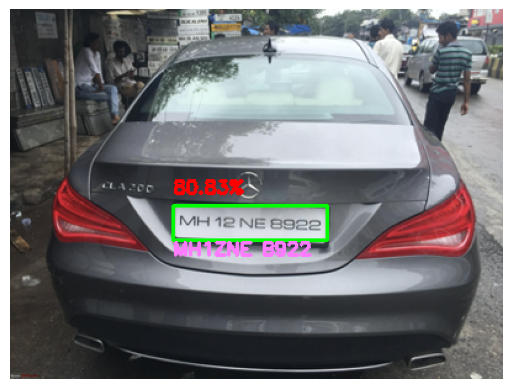

In [92]:
predict_and_plot('/kaggle/working/datasets/cars_license_plate_new/test/images/Cars415.png')